In [ ]:
!pip install numpy pandas scikit-learn joblib tensorflow mediapipe opencv-python matplotlib seaborn

(7007, 126) (7007,)


/tmp/ipykernel_4447/3229037819.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=step_labels, y=step_counts, palette='viridis')


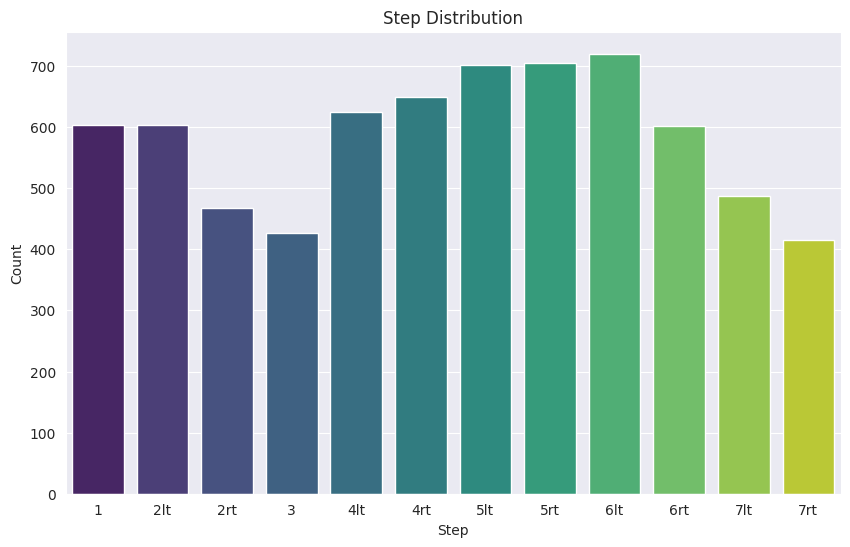

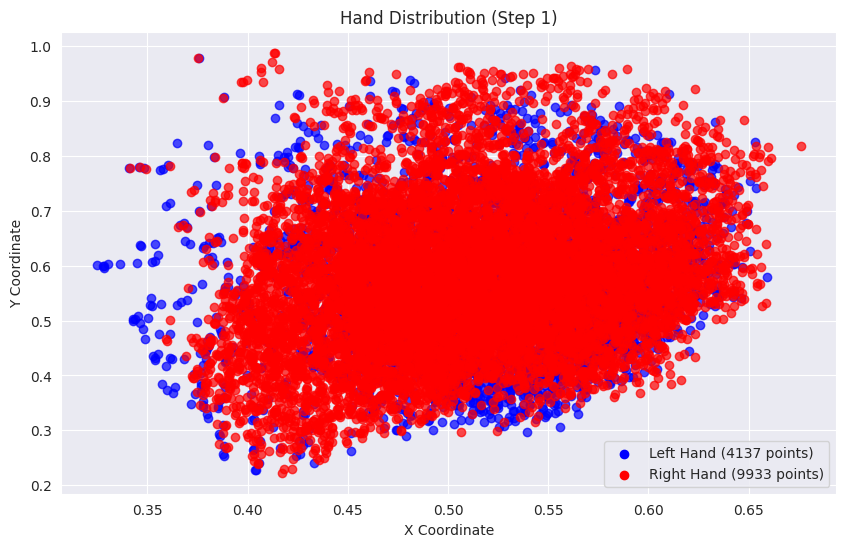

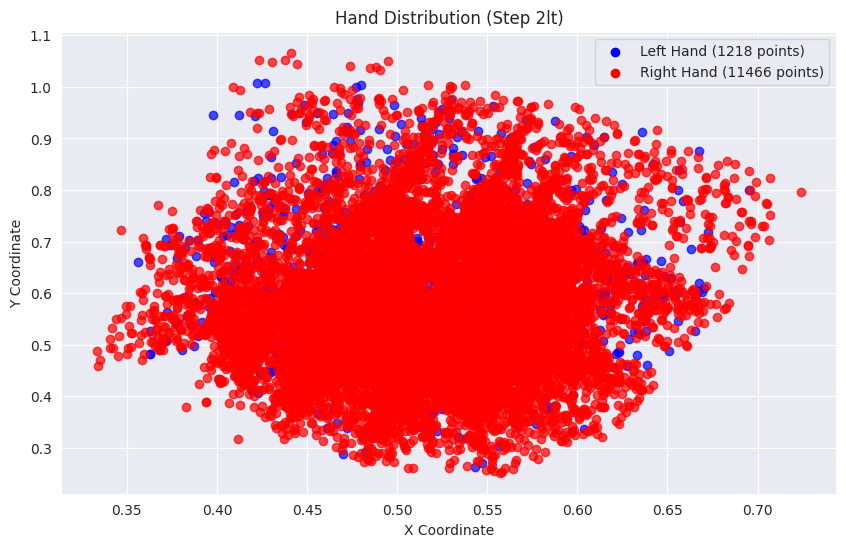

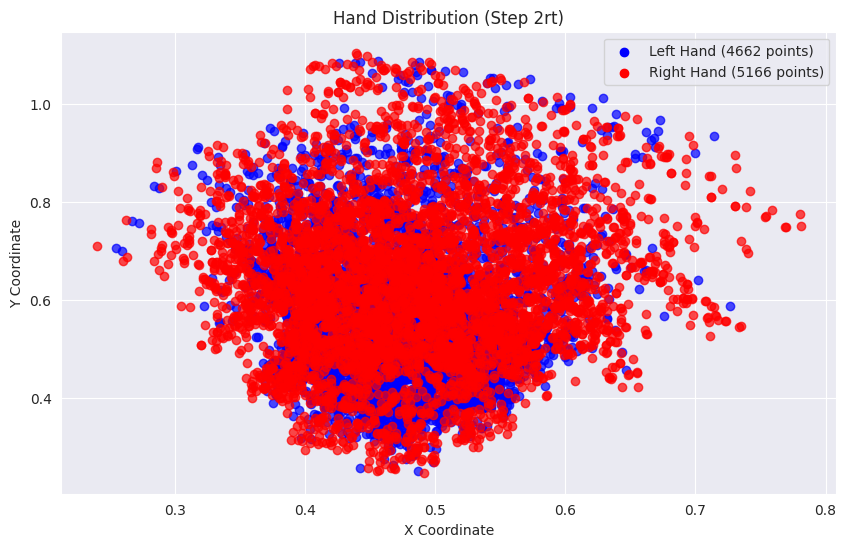

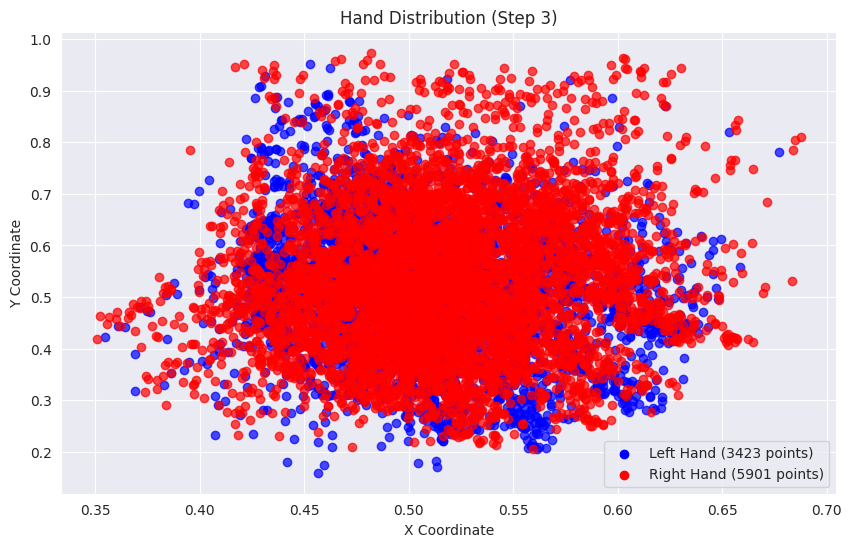

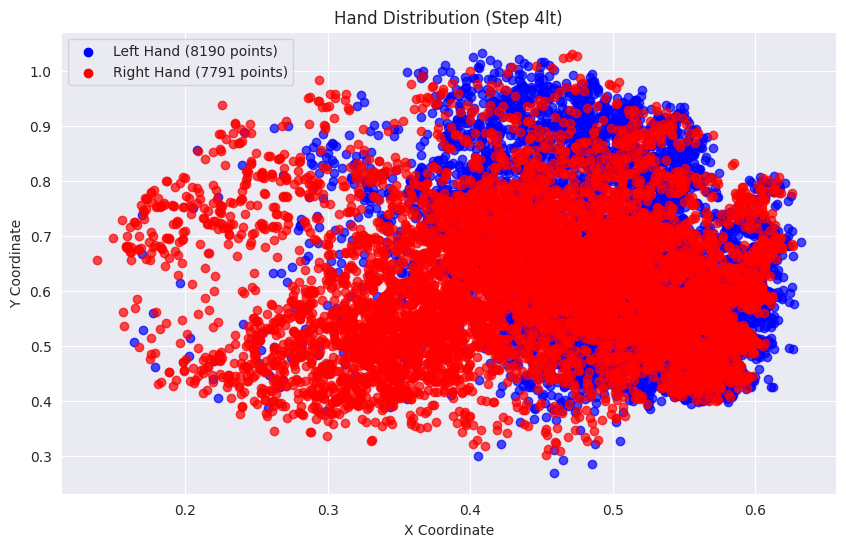

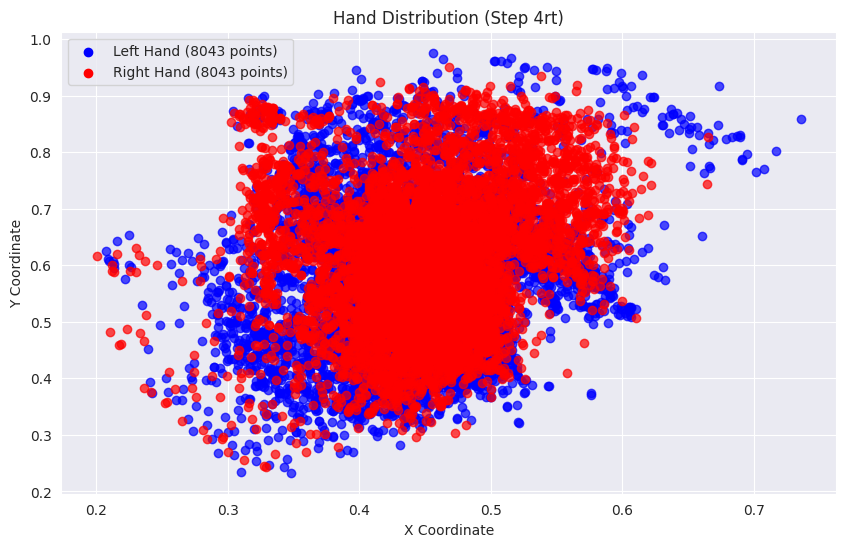

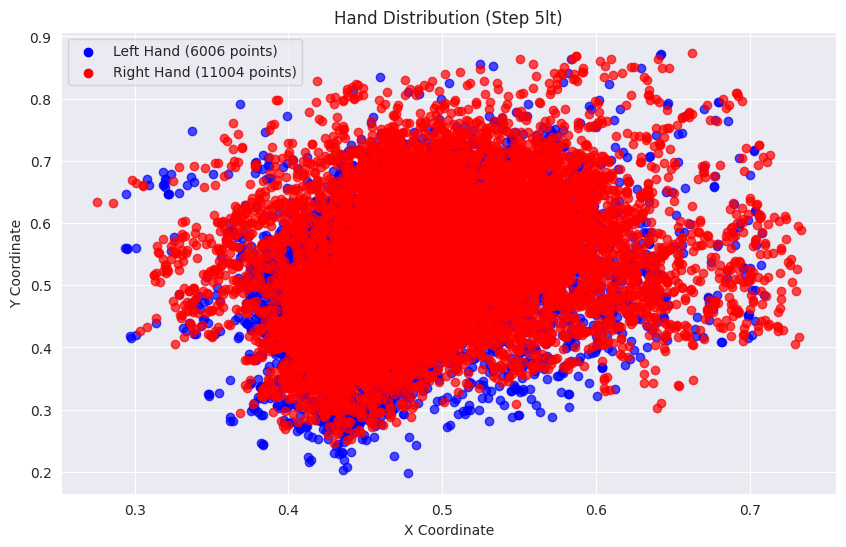

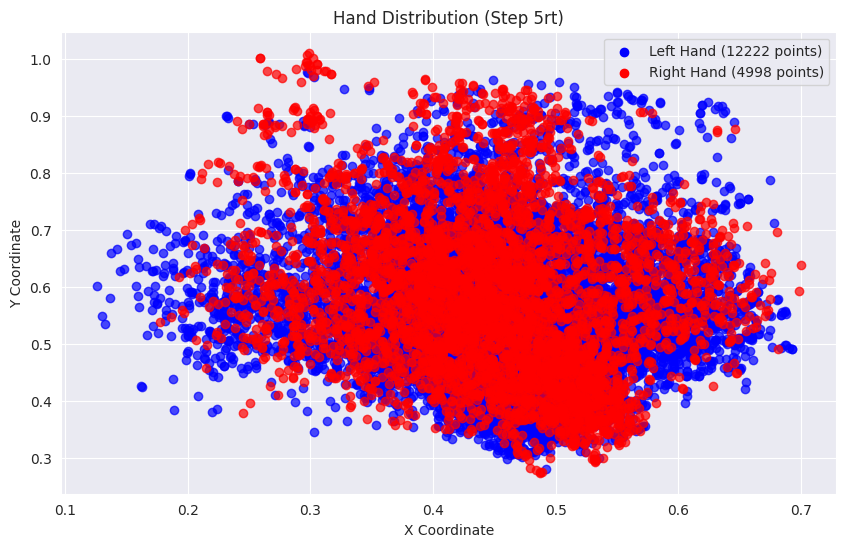

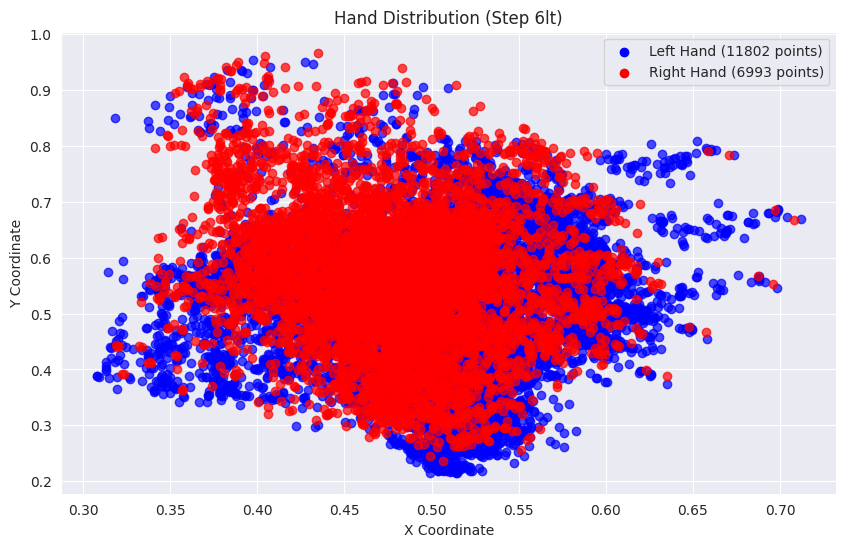

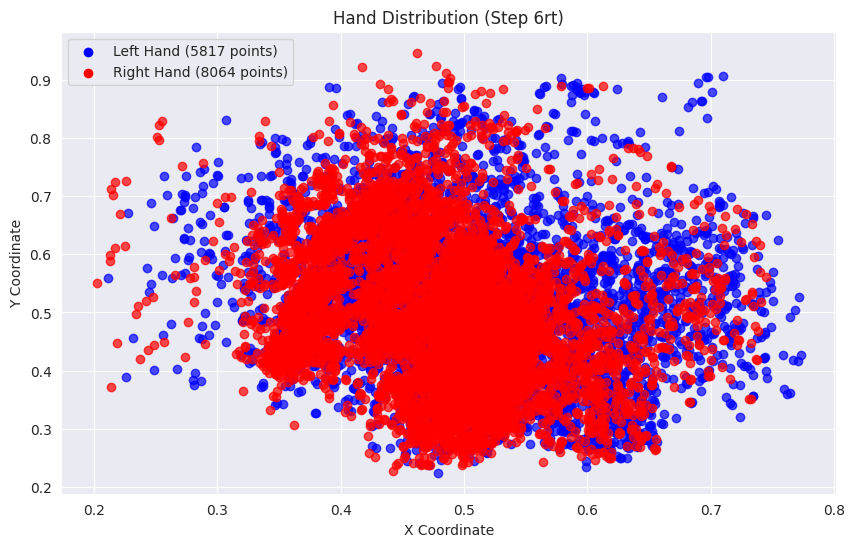

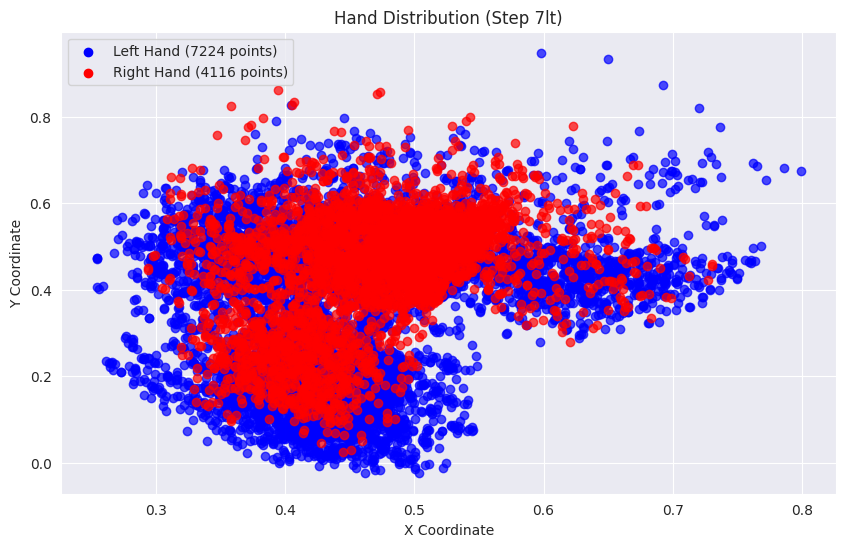

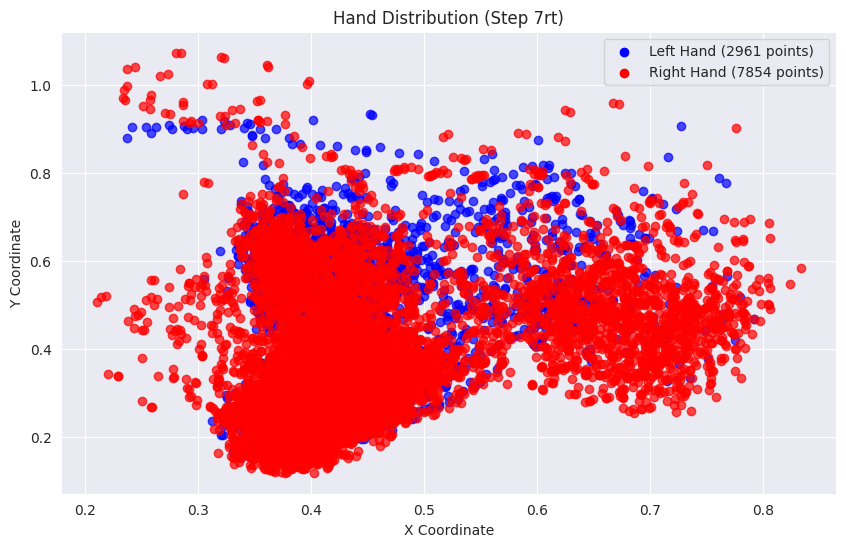

Epoch 1/50
176/176 [==============================] - 2s 5ms/step - loss: 2.0480 - accuracy: 0.3408 - val_loss: 1.6142 - val_accuracy: 0.4864
Epoch 2/50
176/176 [==============================] - 1s 4ms/step - loss: 1.3722 - accuracy: 0.5661 - val_loss: 1.1807 - val_accuracy: 0.5849
Epoch 3/50
176/176 [==============================] - 1s 4ms/step - loss: 1.0696 - accuracy: 0.6525 - val_loss: 0.9589 - val_accuracy: 0.6748
Epoch 4/50
176/176 [==============================] - 1s 4ms/step - loss: 0.9120 - accuracy: 0.7040 - val_loss: 0.8371 - val_accuracy: 0.7254
Epoch 5/50
176/176 [==============================] - 1s 4ms/step - loss: 0.8107 - accuracy: 0.7354 - val_loss: 0.7885 - val_accuracy: 0.7340
Epoch 6/50
176/176 [==============================] - 1s 4ms/step - loss: 0.7573 - accuracy: 0.7479 - val_loss: 0.7047 - val_accuracy: 0.7625
Epoch 7/50
176/176 [==============================] - 1s 4ms/step - loss: 0.6973 - accuracy: 0.7666 - val_loss: 0.6618 - val_accuracy: 0.7910
Epoch 

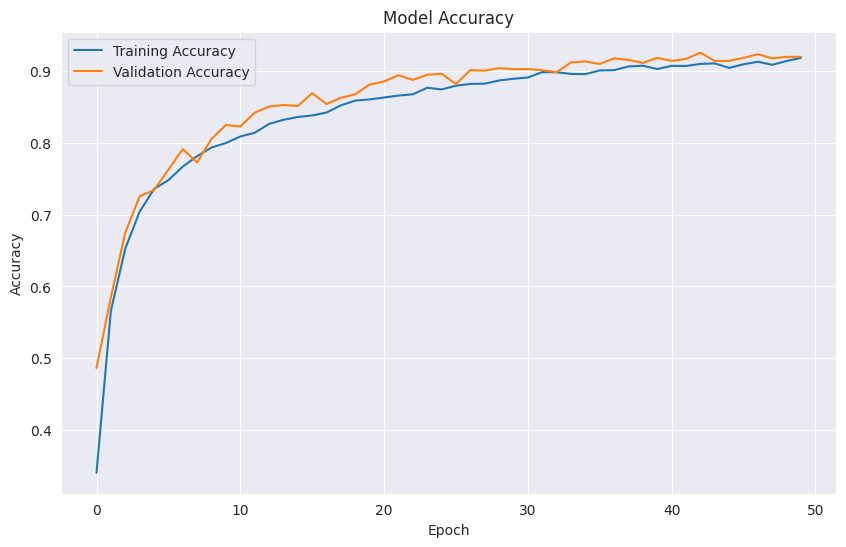

44/44 [==============================] - 0s 1ms/step
Accuracy: 91.94%
F1 Score: 91.37%
Recall: 91.55%


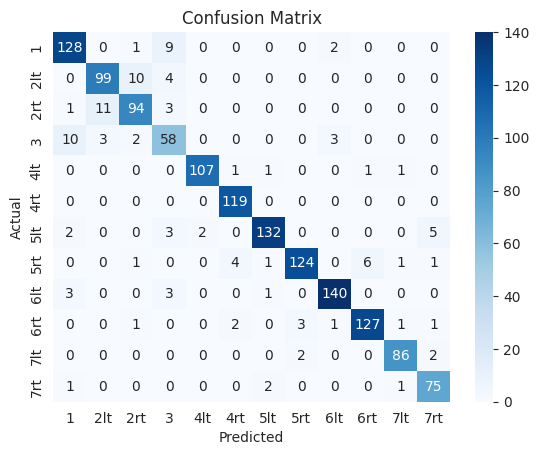

In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping of step names
step_names = ["1", "2lt", "2rt", "3", "4lt", "4rt", "5lt", "5rt", "6lt", "6rt", "7lt", "7rt"]

# Function to parse hand data from a string
def parse_hand_data(hand_str):
    try:
        hand_data = np.array([float(v) for v in hand_str.strip('[]').split(',')])
        return hand_data
    except Exception:
        return np.array([0.0] * 21 * 3)

# Function to load data
def load_data(data_folder):
    X, y = [], []
    for step_idx, step_name in enumerate(step_names):
        file_path = os.path.join(data_folder, f"{step_name}.csv")
        if os.path.isfile(file_path):
            df = pd.read_csv(file_path)

            # Parse left and right hand data
            left_data = df['Left'].apply(parse_hand_data)
            right_data = df['Right'].apply(parse_hand_data)
            step_data = np.concatenate([np.stack(left_data), np.stack(right_data)], axis=1)

            # Append data and labels
            X.append(step_data)
            y.extend([step_idx] * len(step_data))  # Label corresponds to the step index

    X = np.concatenate(X, axis=0)
    y = np.array(y)
    return X, y

# Function to normalize the data
def normalize_data(all_data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(all_data)
    return scaled_data

# Function to create an LSTM model
def create_lstm_model(input_shape, num_classes, dropout):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to visualize the distribution of steps (labels)
def visualize_step_distribution(y, step_labels):
    step_counts = [np.sum(y == step) for step in range(len(step_labels))]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=step_labels, y=step_counts, palette='viridis')
    plt.title("Step Distribution")
    plt.xlabel("Step")
    plt.ylabel("Count")
    plt.show()

# Function to visualize accuracy over epochs
def visualize_accuracy_and_epochs(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to visualize hand keypoint distribution for all steps
def visualize_hand_distribution_all_steps(X, y, num_steps=12):
    # Visualize the distribution of hand keypoints for each step
    for step in range(num_steps):
        # Extract step-specific data
        step_data = X[y == step]
        num_features = step_data.shape[1] // 2  # Left and right hand data are concatenated
        left_hand = step_data[:, :num_features].reshape(-1, 21, 3)
        right_hand = step_data[:, num_features:].reshape(-1, 21, 3)

        # Filter out invalid keypoints with coordinates (0, 0, 0)
        left_hand = left_hand[np.any(left_hand != (0, 0, 0), axis=2)]
        right_hand = right_hand[np.any(right_hand != (0, 0, 0), axis=2)]

        # Reshape again after filtering
        left_hand = left_hand.reshape(-1, 21, 3)
        right_hand = right_hand.reshape(-1, 21, 3)

        # Count total keypoints for each hand
        left_hand_points = left_hand.shape[0] * left_hand.shape[1]
        right_hand_points = right_hand.shape[0] * right_hand.shape[1]

        # Plot the hand keypoints
        plt.figure(figsize=(10, 6))
        for frame in left_hand:
            plt.scatter(frame[:, 0], frame[:, 1], color='blue', alpha=0.7)
        for frame in right_hand:
            plt.scatter(frame[:, 0], frame[:, 1], color='red', alpha=0.7)

        # Add Legend with keypoint counts
        plt.scatter([], [], color='blue', label=f'Left Hand ({left_hand_points} points)')
        plt.scatter([], [], color='red', label=f'Right Hand ({right_hand_points} points)')

        plt.title(f"Hand Distribution (Step {step_names[step]})")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.show()

# Main pipeline for gesture recognition
def generalize_recognition(data_folder):
    X, y = load_data(data_folder)

    print(X.shape, y.shape)

    # Save the dataset for normalization
    joblib.dump(X, 'X.pkl')

    # Visualize the step distribution
    visualize_step_distribution(y, step_names)

    # Visualize the hand distribution for all steps
    visualize_hand_distribution_all_steps(X, y, num_steps=len(step_names))

    # Normalize the data
    X_normalized = normalize_data(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

    # Reshape the data for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Create and train the LSTM model
    model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]), len(step_names), 0.2)
    history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

    # Visualize accuracy
    visualize_accuracy_and_epochs(history)

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test_lstm), axis=1)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.2%}")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.2%}")

    # Save the trained model
    model.save('generalized_lstm_model.keras')

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=step_names, yticklabels=step_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()

# Execute the main pipeline
if __name__ == "__main__":
    data_folder = 'data/landmark'  # Path to the folder containing the CSV files (e.g., 1.csv, 2lt.csv, etc.)
    generalize_recognition(data_folder)



In [9]:
import mediapipe as mp
import numpy as np
import cv2
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import time
from collections import deque

# Step names corresponding to predictions
step_names = ["1", "2lt", "2rt", "3", "4lt", "4rt", "5lt", "5rt", "6lt", "6rt", "7lt", "7rt"]

# Initialize MediaPipe Hands module
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# Load the pre-trained gesture recognition model
model = load_model('generalized_lstm_model.keras')

# Load the existing dataset for normalization
X = joblib.load('X.pkl')

# Function to normalize data
def normalize_data(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

# Function to extract landmarks from a frame
def extract_landmarks_from_frame(frame):
    # Flip the frame horizontally for a mirrored view
    frame = cv2.flip(frame, 1)

    # Convert frame to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame to extract hand landmarks
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands:
        results = hands.process(frame_rgb)

        # If no landmarks are detected, return None
        if not results.multi_hand_landmarks:
            return None, frame

        landmarks = {}
        for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # Determine if the hand is left or right
            hand_type = "Left" if results.multi_handedness[idx].classification[0].label == "Left" else "Right"
            landmarks[hand_type] = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]

            # Draw hand landmarks on the frame
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        return landmarks, frame

# Function to preprocess landmarks for the model
def preprocess_landmarks(landmarks):
    feature_vector = []

    # Add landmarks for the left hand or zeros if not detected
    if 'Left' in landmarks:
        left_hand = landmarks['Left']
        feature_vector.extend([coord for lm in left_hand for coord in lm])
    else:
        feature_vector.extend([0] * 63)

    # Add landmarks for the right hand or zeros if not detected
    if 'Right' in landmarks:
        right_hand = landmarks['Right']
        feature_vector.extend([coord for lm in right_hand for coord in lm])
    else:
        feature_vector.extend([0] * 63)

    return np.array(feature_vector).reshape(1, -1)

# Function to detect gestures from an image
def detect_image(image_path):
    global X

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Extract landmarks from the image
    landmarks, frame_with_landmarks = extract_landmarks_from_frame(image)

    if landmarks:
        # Preprocess the landmarks into a feature vector
        feature_vector = preprocess_landmarks(landmarks)

        # Append the feature vector to the dataset
        X = np.concatenate((X, feature_vector), axis=0)

        # Normalize the data
        X_normalized = normalize_data(X)
        X_last_normalized = X_normalized[-1]
        X_lstm_input = X_last_normalized.reshape((1, 1, X_last_normalized.shape[0]))

        # Make gesture prediction
        predictions = model.predict(X_lstm_input)
        predicted_class = np.argmax(predictions, axis=1)
        predicted_gesture = step_names[predicted_class[0]]
        predicted_gesture = f"Gesture: {predicted_gesture}"

        # Display the predicted gesture on the image
        cv2.putText(frame_with_landmarks, predicted_gesture, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Show the processed image with landmarks and prediction
    cv2.imshow("Image Feed", frame_with_landmarks)

    # Close the image window if 'ESC' is pressed
    while True:
        if cv2.waitKey(1) & 0xFF == 27:  # 27 is the ASCII code for 'ESC'
            break

    cv2.destroyAllWindows()

# Function to detect gestures using a webcam with a timer and reset logic
def detect_camera():
    global X  # Global dataset for storing feature vectors

    # Start video capture from the webcam
    cap = cv2.VideoCapture(0)   # 46 depth ,8 RGB
    hand_detected = False
    last_hand_detected_time = time.time()
    timer_start_time = None
    pass_start_time = None
    wait_start_time = None

    total_time = 0
    step_times = {step: 0 for step in step_names}  # Initialize time tracking for each step
    current_step = None
    step_start_time = None

    prev_frame_time = 0
    new_frame_time = 0

    # Initialize a queue to store recent predictions
    prediction_window = deque(maxlen=10)  # Sliding window for smoothing predictions
    smoothing_threshold = 0.7  # Minimum confidence for stable prediction

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Calculate FPS
        new_frame_time = time.time()
        fps = int(1 / (new_frame_time - prev_frame_time)) if prev_frame_time > 0 else 0
        prev_frame_time = new_frame_time

        # Extract landmarks from the current frame
        landmarks, frame_with_landmarks = extract_landmarks_from_frame(frame)

        if landmarks:
            # Reset the last hand detected time
            last_hand_detected_time = time.time()
            wait_start_time = None

            if not hand_detected:
                # Start the timer when a hand is detected for the first time
                hand_detected = True
                timer_start_time = time.time()

            # Preprocess the landmarks into a feature vector
            feature_vector = preprocess_landmarks(landmarks)

            # Append the feature vector to the dataset
            X = np.concatenate((X, feature_vector), axis=0)

            # Normalize the data
            X_normalized = normalize_data(X)
            X_last_normalized = X_normalized[-1]
            X_lstm_input = X_last_normalized.reshape((1, 1, X_last_normalized.shape[0]))

            # Make gesture prediction
            predictions = model.predict(X_lstm_input)
            predicted_class = np.argmax(predictions, axis=1)[0]
            prediction_window.append(predicted_class)  # Append prediction to the sliding window

            # Compute the smoothed prediction using a majority vote
            most_common_prediction = max(set(prediction_window), key=prediction_window.count)
            confidence = prediction_window.count(most_common_prediction) / len(prediction_window)

            # Apply smoothing threshold
            if confidence >= smoothing_threshold:
                smoothed_gesture = step_names[most_common_prediction]
            else:
                smoothed_gesture = "Uncertain"

            # If the step changes, record the time spent in the previous step
            if current_step != smoothed_gesture and smoothed_gesture != "Uncertain":
                if current_step is not None and step_start_time is not None:
                    step_times[current_step] += time.time() - step_start_time
                current_step = smoothed_gesture
                step_start_time = time.time()

            # Update total time
            elapsed_time = time.time() - timer_start_time
            total_time = elapsed_time

            # Calculate time spent in the current step
            current_step_time = step_times[current_step] + (time.time() - step_start_time)

            # Display smoothed gesture, time in the current step, and total time
            cv2.putText(frame_with_landmarks, f"Gesture: {current_step}", (20, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.putText(frame_with_landmarks, f"Time in {current_step}: {int(current_step_time)}s", (20, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
            cv2.putText(frame_with_landmarks, f"Total Time: {int(total_time)}s", (20, 130),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

            # Display the "Pass" banner if total time exceeds 60 seconds
            if elapsed_time > 60:
                if pass_start_time is None:
                    pass_start_time = time.time()

                # Draw green "Pass" banner
                height, width, _ = frame_with_landmarks.shape
                cv2.rectangle(frame_with_landmarks, (0, height // 3), (width, 2 * height // 3), (0, 255, 0), -1)
                cv2.putText(frame_with_landmarks, "Pass", (width // 2 - 50, height // 2 + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3, cv2.LINE_AA)

                # Reset timer after 5 seconds of showing the "Pass" banner
                if time.time() - pass_start_time > 5:
                    pass_start_time = None
                    timer_start_time = None
                    hand_detected = False

        else:
            if hand_detected:
                if wait_start_time is None:
                    wait_start_time = time.time()

                # If no hand is detected for 1.5 seconds, show "Wait" banner
                if time.time() - wait_start_time >= 1.5:
                    # Prepare the list of steps with less than 20 seconds
                    short_steps = [step for step, time_spent in step_times.items() if time_spent < 20]
                    short_steps_text = " ".join(short_steps)  # Format the steps as a single string

                    # Draw the "Wait" banner
                    height, width, _ = frame_with_landmarks.shape
                    cv2.rectangle(frame_with_landmarks, (0, height // 3), (width, 2 * height // 3), (0, 255, 255), -1)
                    cv2.putText(frame_with_landmarks, "Wait", (width // 2 - 50, height // 2 - 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)

                    # Draw the second line with steps under 20 seconds (small text)
                    cv2.putText(frame_with_landmarks, f"Steps: {short_steps_text}", (20, height // 2 + 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2, cv2.LINE_AA)

            # Reset if no hand is detected for 10 seconds
            if hand_detected and (time.time() - last_hand_detected_time) > 10:
                hand_detected = False
                timer_start_time = None
                pass_start_time = None
                wait_start_time = None

            # Display "No Hand Detected" as text
            cv2.putText(frame_with_landmarks, "No Hand Detected", (20, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        # Display FPS in the bottom-right corner (small size)
        height, width, _ = frame_with_landmarks.shape
        cv2.putText(frame_with_landmarks, f"{fps}", (width - 70, height - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

        # Show the frame with landmarks, timer, and predictions
        cv2.imshow("Webcam Feed", frame_with_landmarks)

        # Break the loop if 'ESC' is pressed
        if cv2.waitKey(1) & 0xFF == 27:  # 27 is the ASCII code for 'ESC'
            break

    # Record the final time for the last detected gesture
    if current_step is not None and step_start_time is not None:
        step_times[current_step] += time.time() - step_start_time

    cap.release()
    cv2.destroyAllWindows()

# Main execution
if __name__ == "__main__":
    # Uncomment one of the lines below to test
    #[detect_image(f"data/image/7rt/{i}.jpg") for i in range(20)]
    detect_camera()


I0000 00:00:1737829399.558329    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829399.559481   41408 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 14ms/step


I0000 00:00:1737829401.923099    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829401.924376   41451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 14ms/step


I0000 00:00:1737829402.489954    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829402.493828   41489 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 14ms/step


I0000 00:00:1737829403.068172    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829403.072561   41527 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 15ms/step


I0000 00:00:1737829404.512264    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829404.515448   41565 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 15ms/step


I0000 00:00:1737829405.001439    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829405.003472   41603 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 17ms/step


I0000 00:00:1737829406.832566    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829406.834312   41641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)
I0000 00:00:1737829407.026601    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829407.029510   41679 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 14ms/step


I0000 00:00:1737829407.262686    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829407.265989   41717 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)
I0000 00:00:1737829407.460940    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829407.468323   41755 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 17ms/step


I0000 00:00:1737829409.216454    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829409.218195   41796 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 16ms/step


I0000 00:00:1737829409.704154    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829409.706531   41834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 15ms/step


I0000 00:00:1737829410.185827    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829410.187228   41872 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 15ms/step


I0000 00:00:1737829410.711252    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829410.714482   41910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 15ms/step


I0000 00:00:1737829411.309849    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829411.311255   41948 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)
I0000 00:00:1737829411.846726    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829411.848533   41986 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 14ms/step


I0000 00:00:1737829412.327934    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829412.329331   42004 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 16ms/step


I0000 00:00:1737829412.866398    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829412.873827   42042 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)


1/1 [==============================] - 0s 14ms/step


I0000 00:00:1737829413.375133    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829413.376619   42081 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)
I0000 00:00:1737829413.914778    4447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737829413.916626   42119 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-130-generic, LLVM 12.0.0)
